In [26]:
import sys
import os

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from IPython.display import display, HTML, Markdown

from datasetsforecast.m3 import M3

from ruptures.detection import Pelt
from statsmodels.tsa.seasonal import STL
from sklearn.linear_model import LinearRegression as SkLearnLinearRegression
from statsmodels.tsa.stattools import acf

current_working_directory = os.getcwd()
project_root = os.path.abspath(os.path.join(current_working_directory, '..'))
if project_root not in sys.path:
    sys.path.insert(0, project_root)
    print(f"Added to sys.path: {project_root}")
else:
    print(f"{project_root} is already in sys.path.")

from testing.deeptsanalysis_metrics import test_deeptsanalysis_metrics

c:\Users\Utilizador\Desktop\Faculdade\Projeto Investigação - Séries Temporais\EasyTest is already in sys.path.


In [3]:
print("Loading M3 Monthly data for plotting...")
Y_df = None
DATA_LOADED_FOR_PLOTTING = False

data_dir = os.path.join(project_root, 'data', 'm3_download')
os.makedirs(data_dir, exist_ok=True)

loaded_data = M3.load(directory=data_dir, group='Monthly')

if isinstance(loaded_data, (list, tuple)) and len(loaded_data) > 0:
    Y_df = loaded_data[0]
elif isinstance(loaded_data, pd.DataFrame):
    Y_df = loaded_data

if Y_df is not None and not Y_df.empty:
    Y_df['ds'] = pd.to_datetime(Y_df['ds'])
    print(f"M3 Monthly data loaded successfully for plotting. Shape: {Y_df.shape}")
    DATA_LOADED_FOR_PLOTTING = True
else:
    print("Failed to load M3 Monthly data for plotting or data is empty.")


Loading M3 Monthly data for plotting...
M3 Monthly data loaded successfully for plotting. Shape: (167562, 3)


In [4]:
def display_parameter_table(parameter_details_list):
    if not parameter_details_list:
        display(Markdown(f"**No parameters**"))

    else:
        df_params = pd.DataFrame(parameter_details_list, columns=["Parameter", "Type", "Default", "Description"])

        styled_df = df_params.style \
            .set_properties(**{  # Default styles for all cells
                'text-align': 'left',
                'vertical-align': 'top', # Align text top for wrapped cells
                'border': '1px solid #ddd', # Lighter border
                'padding': '5px'
            }) \
            .set_properties(subset=['Description'], **{ # Specific styles for Description column
                'min-width': '300px',     # Set a minimum width
                'max-width': '450px',     # Set a maximum width (adjust as needed)
                'white-space': 'normal',  # Allow text wrapping
                'word-wrap': 'break-word' # Break long words if necessary
            }) \
            .set_properties(subset=['Parameter'], **{
                'min-width': '100px',
                'font-weight': 'bold' # Make parameter name bold
                }) \
            .set_properties(subset=['Type'], **{'min-width': '60px'}) \
            .set_properties(subset=['Default'], **{
                'min-width': '120px',
                'white-space': 'normal', # Allow wrapping for potentially long defaults
                'word-wrap': 'break-word'
                }) \
            .set_table_styles([ # Styles for the table header (<th>)
                {'selector': 'th',
                    'props': [('background-color', '#f2f2f2'), # Lighter header
                            ('color', 'black'),
                            ('font-weight', 'bold'),
                            ('text-align', 'left'),
                            ('border', '1px solid #ddd'),
                            ('padding', '5px')]}
            ], overwrite=False) \
            .hide(axis='index') # Hide the default numerical DataFrame index

        # Create a title
        title_html = f"<h3>Parameters Table</h3>"
        display(HTML(title_html))
        # Display the styled DataFrame as HTML
        display(HTML(styled_df.to_html(escape=False))) # escape=False allows HTML in cells if needed, otherwise set True

In [23]:
print("\nProcessing calculated extreme feature values...")
extreme_datasets_info = {} 

calculated_extremes = test_deeptsanalysis_metrics()
if calculated_extremes is not None and isinstance(calculated_extremes, dict) and calculated_extremes:
    feature_keys_using_new_names = [
        "Trend Changes",
        "Trend Strength",            
        "Median Crosses",           
        "Linear Regression Slope",   
        "Linear Regression R2",     
        "Series Forecastability",           
        "Entropy Pairs",             
        "Series Fluctuation",
        "Autocorrelation Relevance",
        "Seasonal Strength",
        "Window Fluctuation"
    ]

    print(f"Expecting features: {feature_keys_using_new_names}")
    print(f"Available features in calculated_extremes: {list(calculated_extremes.keys())}")


    for feature_key in feature_keys_using_new_names:
        if feature_key not in calculated_extremes:
            print(f"Warning: Feature key '{feature_key}' not found in calculated_extremes dictionary. Skipping.")
            continue

        extreme_pair = calculated_extremes[feature_key]
        if not isinstance(extreme_pair, dict) or 'lowest' not in extreme_pair or 'highest' not in extreme_pair:
            print(f"Warning: Data for feature key '{feature_key}' in calculated_extremes is not in the expected format {{'lowest': (id, val), 'highest': (id, val)}}. Skipping.")
            continue

        low_info = extreme_pair.get('lowest', (None, np.nan))
        high_info = extreme_pair.get('highest', (None, np.nan))

        if not (isinstance(low_info, (tuple, list)) and len(low_info) == 2):
            print(f"Warning: 'lowest' data for '{feature_key}' is malformed: {low_info}. Setting to N/A.")
            low_id, low_val = "N/A", np.nan
        else:
            low_id, low_val = low_info

        if not (isinstance(high_info, (tuple, list)) and len(high_info) == 2):
            print(f"Warning: 'highest' data for '{feature_key}' is malformed: {high_info}. Setting to N/A.")
            high_id, high_val = "N/A", np.nan
        else:
            high_id, high_val = high_info

        temp_extreme_info_entry = {
            "low_id": str(low_id) if pd.notna(low_id) and low_id is not None else "N/A",
            "low_val": low_val,
            "high_id": str(high_id) if pd.notna(high_id) and high_id is not None else "N/A",
            "high_val": high_val, 
            "source_metric_method": "Refer to Metrics class" 
        }

        if feature_key in ["Trend Changes", "Trend Strength", "Median Crosses", "Linear Regression Slope", "Linear Regression R2"]:
            temp_extreme_info_entry["conceptual_group"] = "Trend/Regression Analysis"
        elif feature_key in ["Forecastability", "Entropy Pairs", "Series Fluctuation"]:
            temp_extreme_info_entry["conceptual_group"] = "Complexity/Noise/Forecastability Analysis"

        extreme_datasets_info[feature_key] = temp_extreme_info_entry

    if extreme_datasets_info:
        print("\n--- Summary of Extreme Values (New Names) ---")
        for feature, info in extreme_datasets_info.items():
            low_val_str = f"{info['low_val']:.4f}" if pd.notna(info['low_val']) else "N/A"
            high_val_str = f"{info['high_val']:.4f}" if pd.notna(info['high_val']) else "N/A"
            print(f"  Feature: {feature} (Group: {info.get('conceptual_group', 'N/A')})")
            print(f"    Lowest:  ID = {info['low_id']}, Value = {low_val_str}")
            print(f"    Highest: ID = {info['high_id']}, Value = {high_val_str}")
    else:
        print("\nNo extreme dataset information was mapped. 'calculated_extremes' might be empty, all keys might have been missing, or data was malformed.")

elif calculated_extremes is None:
    print("\nSkipping processing: 'calculated_extremes' is None (was not populated).")
else: # calculated_extremes is not None, but might be empty dict or wrong type
    print(f"\nSkipping processing: 'calculated_extremes' is not a non-empty dictionary (type: {type(calculated_extremes)}).")


Processing calculated extreme feature values...

Loading M3 Monthly data (will download to 'c:\Users\Utilizador\Desktop\Faculdade\Projeto Investigação - Séries Temporais\EasyTest\data\m3_download' if needed)...
Data loaded successfully.

Analyzing 1428 monthly time series using the Metrics class...
Processed 1/1428 series... (Checked 1, Skipped 0)
Processed 100/1428 series... (Checked 100, Skipped 0)
Processed 200/1428 series... (Checked 200, Skipped 0)
Processed 300/1428 series... (Checked 300, Skipped 0)
Processed 400/1428 series... (Checked 400, Skipped 0)
Processed 500/1428 series... (Checked 500, Skipped 0)
Processed 600/1428 series... (Checked 600, Skipped 0)
Processed 700/1428 series... (Checked 700, Skipped 0)
Processed 800/1428 series... (Checked 800, Skipped 0)
Processed 900/1428 series... (Checked 900, Skipped 0)
Processed 1000/1428 series... (Checked 1000, Skipped 0)
Processed 1100/1428 series... (Checked 1100, Skipped 0)
Processed 1200/1428 series... (Checked 1200, Skippe

## trend_strength

Computes the strength of a trend within the time-series.  
**Low value:** A value close to zero means there are few/none indicators of a trend in the time series.  
**High value:** A value close to one means there are strong signs of the series containing a trend.

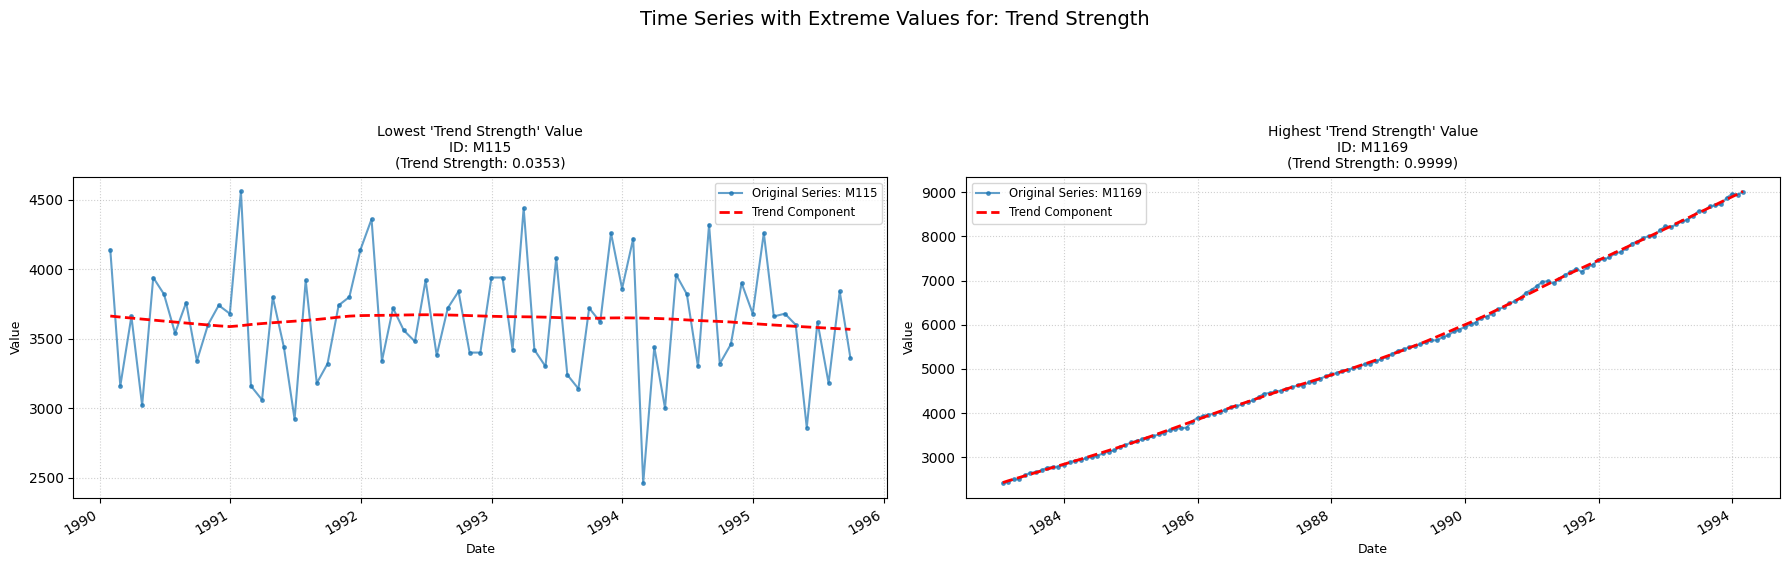

In [33]:
# --- Feature to Plot ---
feature_to_plot = "Trend Strength"

# --- Check if data for the feature is available ---
if feature_to_plot not in extreme_datasets_info or not extreme_datasets_info[feature_to_plot]:
    fig, ax_placeholder = plt.subplots(1, 1, figsize=(9, 5))
    ax_placeholder.text(0.5, 0.5, f"No extreme data found for\n'{feature_to_plot}'", ha='center', va='center', fontsize=12)
    ax_placeholder.set_xticks([])
    ax_placeholder.set_yticks([])
    ax_placeholder.set_title(f"Extreme Values: {feature_to_plot}")
    plt.show()
else:
    details = extreme_datasets_info[feature_to_plot]
    ids_to_process_map = {
        f"Lowest '{feature_to_plot}' Value": details["low_id"],
        f"Highest '{feature_to_plot}' Value": details["high_id"]
    }
    
    stored_values_map = {
        f"Lowest '{feature_to_plot}' Value": details["low_val"],
        f"Highest '{feature_to_plot}' Value": details["high_val"]
    }

    valid_plots_info = []
    for desc, target_id in ids_to_process_map.items():
        if target_id != "N/A" and target_id is not None:
            valid_plots_info.append({"desc": desc, "id": str(target_id), "stored_val": stored_values_map[desc]})

    if not valid_plots_info:
        fig, ax_placeholder = plt.subplots(1, 1, figsize=(9, 5))
        ax_placeholder.text(0.5, 0.5, f"No valid series IDs found for\n'{feature_to_plot}' extremes.", ha='center', va='center', fontsize=12)
        ax_placeholder.set_xticks([])
        ax_placeholder.set_yticks([])
        ax_placeholder.set_title(f"Extreme Values: {feature_to_plot}")
        plt.show()
    else:
        num_plots = len(valid_plots_info)
        fig, axes = plt.subplots(1, num_plots, figsize=(9 * num_plots, 5.5), squeeze=False)
        axes = axes.flatten() 

        for i, plot_info in enumerate(valid_plots_info):
            ax = axes[i]
            target_id = plot_info["id"]
            plot_title_desc = plot_info["desc"]
            stored_feature_val = plot_info["stored_val"]

            if 'Y_df' not in globals() or Y_df is None:
                ax.set_title(f"{plot_title_desc}\nID: {target_id}\n(Y_df MISSING)")
                ax.text(0.5, 0.5, 'Y_df MISSING', ha='center', va='center')
                ax.set_xticks([]); ax.set_yticks([])
                continue

            series_df = Y_df[Y_df['unique_id'] == target_id].sort_values('ds')

            if series_df.empty:
                ax.set_title(f"{plot_title_desc}\nID: {target_id}\n(Data Missing)")
                ax.text(0.5, 0.5, 'Data Missing', ha='center', va='center')
                ax.set_xticks([]); ax.set_yticks([])
                continue

            series_np = series_df['y'].to_numpy()
            series_dates = series_df['ds']

            seasonal_period_for_stl = 12 
            seasonal_smoother_len = 7  
            
            if len(series_np) <= 2 * seasonal_smoother_len :
                ax.set_title(f"{plot_title_desc}\nID: {target_id}\n(Series Too Short for STL: {len(series_np)})")
                ax.text(0.5, 0.5, 'Series Too Short for STL', ha='center', va='center')
                ax.set_xticks([]); ax.set_yticks([])
                continue

            # --- STL Decomposition for "Trend Strength" ---
            recalculated_feature_value = np.nan
            trend_component_to_plot = None
            
            try:
                stl = STL(series_np, period=seasonal_period_for_stl, seasonal=seasonal_smoother_len, robust=True)
                res = stl.fit()
                
                trend_component_to_plot = res.trend
                seasonal_component = res.seasonal 
                remainder_component = res.resid  

                var_R = np.var(remainder_component, ddof=1)
                var_TR = np.var(series_np - seasonal_component, ddof=1) 
                
                if var_TR <= 1e-10:
                    recalculated_feature_value = 0.0
                else:
                    recalculated_feature_value = max(0.0, 1.0 - (var_R / var_TR))
            except Exception as e:
                recalculated_feature_value = "STL Error"


            # --- Plotting ---
            ax.plot(series_dates, series_np, marker='.', linestyle='-', markersize=5, label=f"Original Series: {target_id}", alpha=0.7)

            if trend_component_to_plot is not None:
                ax.plot(series_dates, trend_component_to_plot, linestyle='--', color='red', lw=2, label="Trend Component")

            title_parts = [f"{plot_title_desc}", f"ID: {target_id}"]

            if pd.notna(stored_feature_val):
                title_parts.append(f"(Trend Strength: {stored_feature_val if isinstance(stored_feature_val, str) else f'{stored_feature_val:.4f}'})")
            
            ax.set_title("\n".join(title_parts), fontsize=10)
            
            if any(ax.get_legend_handles_labels()[1]):
                ax.legend(fontsize='small', loc='best')
            
            ax.set_xlabel("Date", fontsize=9)
            ax.set_ylabel("Value", fontsize=9)
            ax.grid(True, linestyle=':', alpha=0.6)
            plt.setp(ax.get_xticklabels(), rotation=30, ha='right')

        fig.suptitle(f"Time Series with Extreme Values for: {feature_to_plot}", fontsize=14, y=1.05 if num_plots > 0 else 0.95)
        plt.tight_layout(rect=[0, 0.03, 1, 0.93])
        plt.show()
        plt.close(fig)


In [7]:
parameter_details_list = [
    {
        "Parameter": "period", "Type": "int", 
        "Description": "Frequency of the time series (e.g. 12 for monthly)", 
        "Default": "'1'"
    },
    {
        "Parameter": "seasonal", "Type": "int",
        "Description": "Length of the seasonal smoother (must be odd).",
        "Default": "7"
    },
    {
        "Parameter": "robust", "Type": "bool",
        "Description": "Flag for robust fitting.",
        "Default": "False"
    }
]

display_parameter_table(
    parameter_details_list)

Parameter,Type,Default,Description
period,int,'1',Frequency of the time series (e.g. 12 for monthly)
seasonal,int,7,Length of the seasonal smoother (must be odd).
robust,bool,False,Flag for robust fitting.


## median_crosses

Counts the number of times a time-series crosses the median line.  
**Low value:** Means there are few/none oscillations across the time-series.  
**High value:** Means there are frequent oscillations across the time-series.

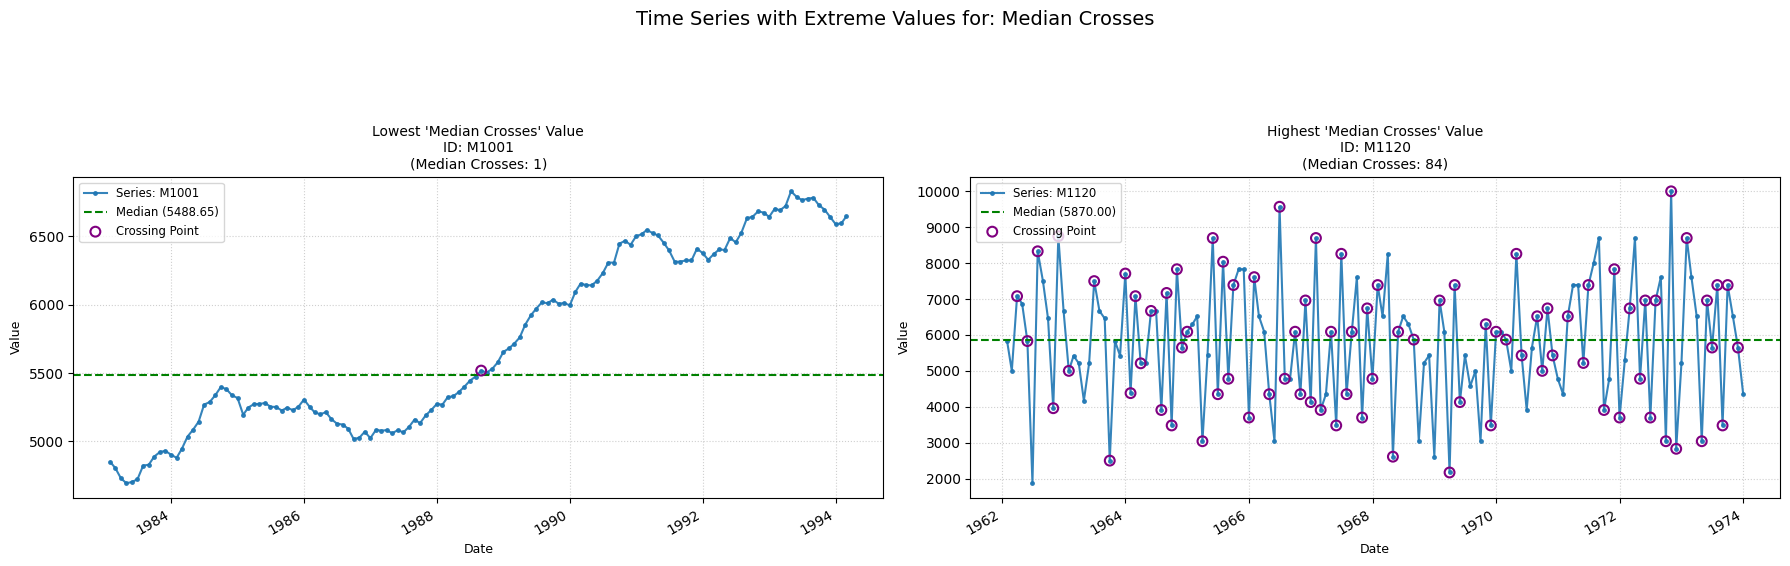

In [8]:
# --- Feature to Plot ---
feature_to_plot = "Median Crosses"

# --- Check if data for the feature is available ---
if 'extreme_datasets_info' not in globals() or not extreme_datasets_info or \
   feature_to_plot not in extreme_datasets_info or not extreme_datasets_info[feature_to_plot]:
    # This check is more robust to ensure extreme_datasets_info exists and has the key
    fig, ax_placeholder = plt.subplots(1, 1, figsize=(9, 5))
    ax_placeholder.text(0.5, 0.5, f"No extreme data found for\n'{feature_to_plot}'", ha='center', va='center', fontsize=12)
    ax_placeholder.set_xticks([])
    ax_placeholder.set_yticks([])
    ax_placeholder.set_title(f"Extreme Values: {feature_to_plot}")
    plt.show()
else:
    details = extreme_datasets_info[feature_to_plot]
    ids_to_process_map = {
        f"Lowest '{feature_to_plot}' Value": details["low_id"],
        f"Highest '{feature_to_plot}' Value": details["high_id"]
    }
    
    stored_values_map = {
        f"Lowest '{feature_to_plot}' Value": details["low_val"],
        f"Highest '{feature_to_plot}' Value": details["high_val"]
    }

    valid_plots_info = []
    for desc, target_id in ids_to_process_map.items():
        if target_id != "N/A" and target_id is not None:
            valid_plots_info.append({"desc": desc, "id": str(target_id), "stored_val": stored_values_map[desc]})

    if not valid_plots_info:
        fig, ax_placeholder = plt.subplots(1, 1, figsize=(9, 5))
        ax_placeholder.text(0.5, 0.5, f"No valid series IDs found for\n'{feature_to_plot}' extremes.", ha='center', va='center', fontsize=12)
        ax_placeholder.set_xticks([])
        ax_placeholder.set_yticks([])
        ax_placeholder.set_title(f"Extreme Values: {feature_to_plot}")
        plt.show()
    else:
        num_plots = len(valid_plots_info)
        fig, axes = plt.subplots(1, num_plots, figsize=(9 * num_plots, 5.5), squeeze=False)
        axes = axes.flatten() 

        for i, plot_info in enumerate(valid_plots_info):
            ax = axes[i]
            target_id = plot_info["id"]
            plot_title_desc = plot_info["desc"]
            stored_feature_val = plot_info["stored_val"]

            if 'Y_df' not in globals() or Y_df is None:
                ax.set_title(f"{plot_title_desc}\nID: {target_id}\n(Y_df MISSING)")
                ax.text(0.5, 0.5, 'Y_df MISSING', ha='center', va='center')
                ax.set_xticks([]); ax.set_yticks([])
                continue

            series_df = Y_df[Y_df['unique_id'] == target_id].sort_values('ds')

            if series_df.empty:
                ax.set_title(f"{plot_title_desc}\nID: {target_id}\n(Data Missing)")
                ax.text(0.5, 0.5, 'Data Missing', ha='center', va='center')
                ax.set_xticks([]); ax.set_yticks([])
                continue

            series_np = series_df['y'].to_numpy()
            series_dates = series_df['ds']
            
            # Median crosses calculation requires at least 2 points to have a crossing.
            if len(series_np) < 2:
                ax.set_title(f"{plot_title_desc}\nID: {target_id}\n(Series Too Short: {len(series_np)})")
                ax.text(0.5, 0.5, 'Series Too Short', ha='center', va='center')
                ax.set_xticks([]); ax.set_yticks([])
                continue

            # --- Calculation for "Median Crosses" ---
            recalculated_feature_value = np.nan
            crossing_point_indices_for_plot = []
            median_val = np.nan 

            if len(series_np) > 0 : # Ensure series is not empty for median calculation
                median_val = np.median(series_np)
                
                num_crossings = 0
                if len(series_np) > 1:
                    above_median = series_np > median_val
                    for k_idx in range(len(series_np) - 1):
                        if above_median[k_idx] != above_median[k_idx+1]:
                            num_crossings += 1
                            crossing_point_indices_for_plot.append(k_idx + 1)
                recalculated_feature_value = num_crossings


            # --- Plotting ---
            ax.plot(series_dates, series_np, marker='.', linestyle='-', markersize=5, label=f"Series: {target_id}", alpha=0.9)

            if pd.notna(median_val):
                ax.axhline(median_val, color='green', linestyle='--', lw=1.5, label=f'Median ({median_val:.2f})')

            if crossing_point_indices_for_plot:
                # Get dates and values for crossing points for scatter plot
                crossing_dates = series_dates.iloc[crossing_point_indices_for_plot]
                crossing_values = series_np[crossing_point_indices_for_plot]
                ax.scatter(crossing_dates, crossing_values, marker='o', s=50,
                        edgecolor='purple', facecolor='none', lw=1.5, label='Crossing Point', zorder=5)

            title_parts = [f"{plot_title_desc}", f"ID: {target_id}"]

            if pd.notna(stored_feature_val):
                title_parts.append(f"(Median Crosses: {stored_feature_val if isinstance(stored_feature_val, str) else f'{stored_feature_val:.0f}'})")
            
            ax.set_title("\n".join(title_parts), fontsize=10)
            
            if any(ax.get_legend_handles_labels()[1]): 
                ax.legend(fontsize='small', loc='best')
            
            ax.set_xlabel("Date", fontsize=9)
            ax.set_ylabel("Value", fontsize=9)
            ax.grid(True, linestyle=':', alpha=0.6)
            plt.setp(ax.get_xticklabels(), rotation=30, ha='right')

        fig.suptitle(f"Time Series with Extreme Values for: {feature_to_plot}", fontsize=14, y=1.05 if num_plots > 0 else 0.95)
        plt.tight_layout(rect=[0, 0.03, 1, 0.93])
        plt.show()
        plt.close(fig)

In [9]:
parameter_details_list = [
]

display_parameter_table(
    parameter_details_list)

**No parameters**

## trend_changes

Detects the number of points where the trend changes.  
**Low value:** The trend has few/none shifting points, and is constant through time.  
**High value:** The trend is constantly shifting, provoking many structural changes.

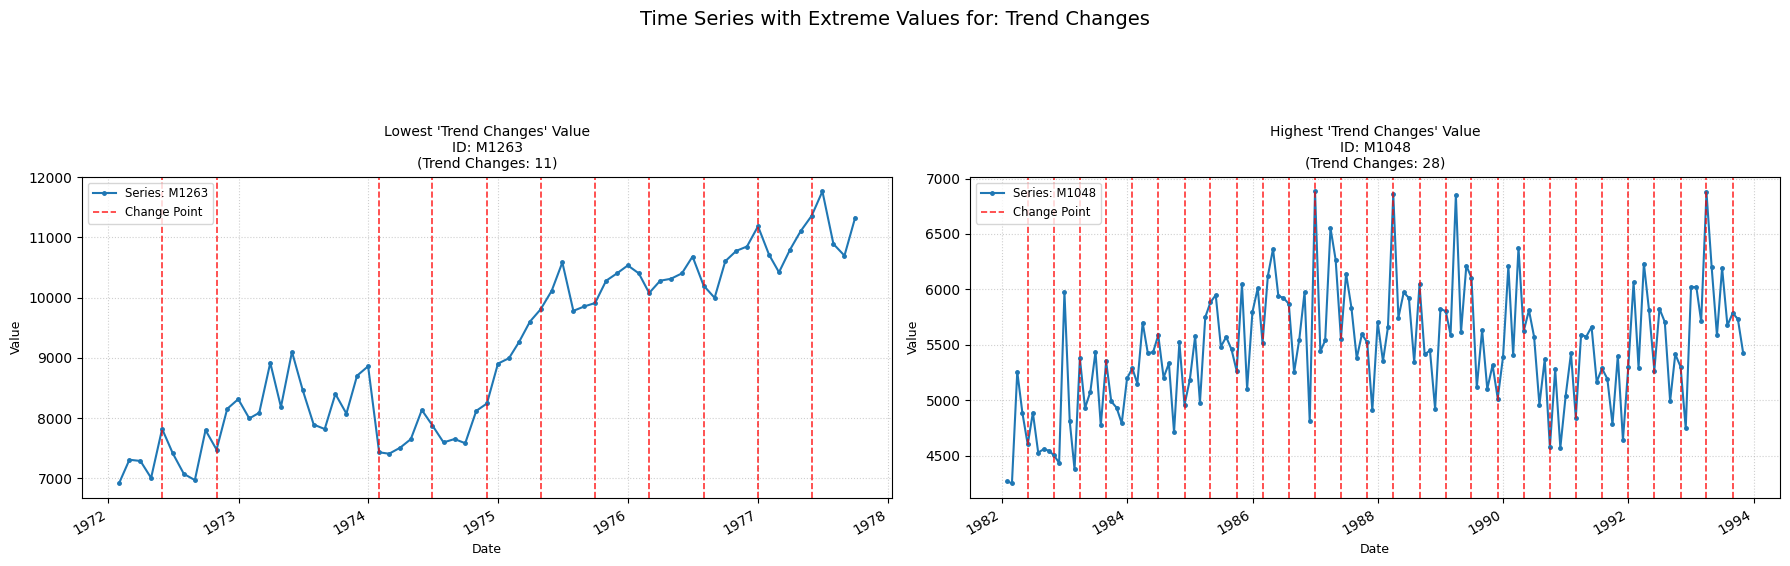

In [10]:
# --- Feature to Plot ---
feature_to_plot = "Trend Changes"

# --- Check if data for the feature is available ---
if feature_to_plot not in extreme_datasets_info or not extreme_datasets_info[feature_to_plot]:
    fig, ax_placeholder = plt.subplots(1, 1, figsize=(9, 5))
    ax_placeholder.text(0.5, 0.5, f"No extreme data found for\n'{feature_to_plot}'", ha='center', va='center', fontsize=12)
    ax_placeholder.set_xticks([])
    ax_placeholder.set_yticks([])
    ax_placeholder.set_title(f"Extreme Values: {feature_to_plot}")
    plt.show()
else:
    details = extreme_datasets_info[feature_to_plot]
    ids_to_process_map = {
        "Lowest 'Trend Changes' Value": details["low_id"],
        "Highest 'Trend Changes' Value": details["high_id"]
    }

    # Stored feature values (count of trend changes)
    stored_values_map = {
        "Lowest 'Trend Changes' Value": details["low_val"],
        "Highest 'Trend Changes' Value": details["high_val"]
    }

    # Filter out N/A IDs for plotting
    valid_plots_info = []
    for desc, target_id in ids_to_process_map.items():
        if target_id != "N/A" and target_id is not None:
            valid_plots_info.append({"desc": desc, "id": target_id, "stored_val": stored_values_map[desc]})

    if not valid_plots_info:
        fig, ax_placeholder = plt.subplots(1, 1, figsize=(9, 5))
        ax_placeholder.text(0.5, 0.5, f"No valid series IDs found for\n'{feature_to_plot}' extremes.", ha='center', va='center', fontsize=12)
        ax_placeholder.set_xticks([])
        ax_placeholder.set_yticks([])
        ax_placeholder.set_title(f"Extreme Values: {feature_to_plot}")
        plt.show()
    else:
        num_plots = len(valid_plots_info)
        fig, axes = plt.subplots(1, num_plots, figsize=(9 * num_plots, 5.5), squeeze=False)
        axes = axes.flatten()
        for i, plot_info in enumerate(valid_plots_info):
            ax = axes[i]
            target_id = plot_info["id"]
            plot_title_desc = plot_info["desc"]
            stored_feature_val = plot_info["stored_val"]

            if 'Y_df' not in globals() or Y_df is None:
                ax.set_title(f"{plot_title_desc}\nID: {target_id}\n(Y_df MISSING)")
                ax.text(0.5, 0.5, 'Y_df MISSING', ha='center', va='center')
                ax.set_xticks([]); ax.set_yticks([])
                continue

            series_df = Y_df[Y_df['unique_id'] == target_id].sort_values('ds')

            if series_df.empty:
                ax.set_title(f"{plot_title_desc}\nID: {target_id}\n(Data Missing)")
                ax.text(0.5, 0.5, 'Data Missing', ha='center', va='center')
                ax.set_xticks([]); ax.set_yticks([])
                continue

            series_np = series_df['y'].to_numpy()
            series_dates = series_df['ds']

            if len(series_np) < 2: # Pelt needs at least 2 points for default min_size
                ax.set_title(f"{plot_title_desc}\nID: {target_id}\n(Series Too Short: {len(series_np)})")
                ax.text(0.5, 0.5, 'Series Too Short', ha='center', va='center')
                ax.set_xticks([]); ax.set_yticks([])
                continue

            recalculated_feature_value = 0 
            bkps_to_plot = []

            pelt_detector = Pelt(model="l2", min_size=2, jump=5)
            pen_value = np.log(len(series_np)) if len(series_np) > 1 else 0
            pelt_detector.fit(series_np)
            bkps_indices = pelt_detector.predict(pen=pen_value)
            
            if bkps_indices and len(bkps_indices) > 1:
                bkps_to_plot = [b for b in bkps_indices[:-1] if 0 < b < len(series_np)]
                recalculated_feature_value = len(bkps_to_plot)
            
            # --- Plotting ---
            ax.plot(series_dates, series_np, marker='.', linestyle='-', markersize=5, label=f"Series: {target_id}")

            title_parts = [f"{plot_title_desc}", f"ID: {target_id}"]
            if pd.notna(stored_feature_val):
                title_parts.append(f"(Trend Changes: {stored_feature_val if isinstance(stored_feature_val, str) else f'{stored_feature_val:.0f}'})")
            
            ax.set_title("\n".join(title_parts), fontsize=10)

            if bkps_to_plot:
                first_bkp_line = True
                for b_idx in bkps_to_plot:
                    if 0 < b_idx <= len(series_dates):
                        plot_date_idx = b_idx -1
                        if plot_date_idx < 0: continue

                        b_date = series_dates.iloc[plot_date_idx]
                        line_label = 'Change Point' if first_bkp_line else None
                        ax.axvline(b_date, color='red', linestyle='--', lw=1.2, alpha=0.8, label=line_label)
                        first_bkp_line = False
            
            if any(ax.get_legend_handles_labels()[1]): 
                ax.legend(fontsize='small', loc='best')
            
            ax.set_xlabel("Date", fontsize=9)
            ax.set_ylabel("Value", fontsize=9)
            ax.grid(True, linestyle=':', alpha=0.6)
            plt.setp(ax.get_xticklabels(), rotation=30, ha='right')
        

        fig.suptitle(f"Time Series with Extreme Values for: {feature_to_plot}", fontsize=14, y=1.05 if num_plots > 0 else 0.95)
        plt.tight_layout(rect=[0, 0.03, 1, 0.93])
        plt.show()
        plt.close(fig)

In [11]:
parameter_details_list = [
    {
        "Parameter": "model", "Type": "str", 
        "Description": "Cost function model (e.g., 'l1', 'l2', 'rbf')", 
        "Default": "'l2'"
    },
    {
        "Parameter": "min_size", "Type": "int",
        "Description": "Minimum number of samples in a segment.",
        "Default": "2"
    },
    {
        "Parameter": "jump", "Type": "int",
        "Description": "Subsample window for considering change points.",
        "Default": "5"
    },
    {
        "Parameter": "params", "Type": "dict or None",
        "Description": "Additional parameters dictionary for the cost 'model'.",
        "Default": "None"
    },
    {
        "Parameter": "custom_cost", "Type": "BaseCost or None",
        "Description": "Custom cost function (overrides 'model').",
        "Default": "None"
    }
]

display_parameter_table(
    parameter_details_list)

Parameter,Type,Default,Description
model,str,'l2',"Cost function model (e.g., 'l1', 'l2', 'rbf')"
min_size,int,2,Minimum number of samples in a segment.
jump,int,5,Subsample window for considering change points.
params,dict or None,None,Additional parameters dictionary for the cost 'model'.
custom_cost,BaseCost or None,None,Custom cost function (overrides 'model').


## linear_regression_slope

Measures the overall linear trend slope.  
**Low value:** A negative value means there is a downward trend.  
**High value:** A positive value means an upward trend.

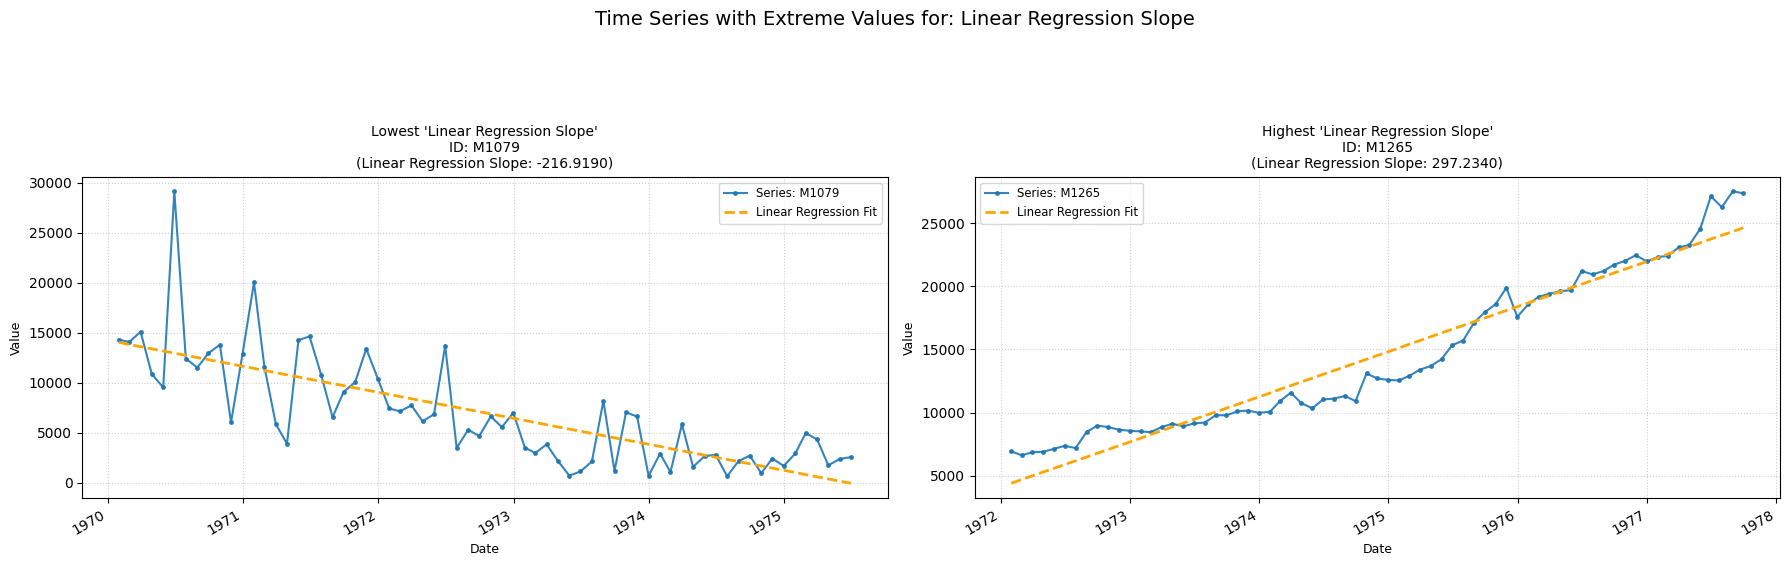

In [12]:
# --- Feature to Plot ---
feature_to_plot = "Linear Regression Slope"

# --- Check if data for the feature is available ---
if 'extreme_datasets_info' not in globals() or not extreme_datasets_info or \
   feature_to_plot not in extreme_datasets_info or not extreme_datasets_info[feature_to_plot]:
    fig, ax_placeholder = plt.subplots(1, 1, figsize=(9, 5))
    ax_placeholder.text(0.5, 0.5, f"No extreme data found for\n'{feature_to_plot}'", ha='center', va='center', fontsize=12)
    ax_placeholder.set_xticks([])
    ax_placeholder.set_yticks([])
    ax_placeholder.set_title(f"Extreme Values: {feature_to_plot}")
    plt.show()
else:
    details = extreme_datasets_info[feature_to_plot]
    ids_to_process_map = {
        f"Lowest '{feature_to_plot}'": details["low_id"],
        f"Highest '{feature_to_plot}'": details["high_id"]
    }
    
    stored_values_map = {
        f"Lowest '{feature_to_plot}'": details["low_val"],
        f"Highest '{feature_to_plot}'": details["high_val"]
    }

    valid_plots_info = []
    for desc, target_id in ids_to_process_map.items():
        if target_id != "N/A" and target_id is not None:
            valid_plots_info.append({"desc": desc, "id": str(target_id), "stored_val": stored_values_map[desc]})

    if not valid_plots_info:
        fig, ax_placeholder = plt.subplots(1, 1, figsize=(9, 5))
        ax_placeholder.text(0.5, 0.5, f"No valid series IDs found for\n'{feature_to_plot}' extremes.", ha='center', va='center', fontsize=12)
        ax_placeholder.set_xticks([])
        ax_placeholder.set_yticks([])
        ax_placeholder.set_title(f"Extreme Values: {feature_to_plot}")
        plt.show()
    else:
        num_plots = len(valid_plots_info)
        fig, axes = plt.subplots(1, num_plots, figsize=(9 * num_plots, 5.5), squeeze=False)
        axes = axes.flatten() 

        for i, plot_info in enumerate(valid_plots_info):
            ax = axes[i]
            target_id = plot_info["id"]
            plot_title_desc = plot_info["desc"]
            stored_feature_val = plot_info["stored_val"]

            if 'Y_df' not in globals() or Y_df is None:
                ax.set_title(f"{plot_title_desc}\nID: {target_id}\n(Y_df MISSING)")
                ax.text(0.5, 0.5, 'Y_df MISSING', ha='center', va='center')
                ax.set_xticks([]); ax.set_yticks([])
                continue

            series_df = Y_df[Y_df['unique_id'] == target_id].sort_values('ds')

            if series_df.empty:
                ax.set_title(f"{plot_title_desc}\nID: {target_id}\n(Data Missing)")
                ax.text(0.5, 0.5, 'Data Missing', ha='center', va='center')
                ax.set_xticks([]); ax.set_yticks([])
                continue

            series_np = series_df['y'].to_numpy()
            series_dates = series_df['ds']
            
            # Linear regression requires at least 2 points.
            if len(series_np) < 2:
                ax.set_title(f"{plot_title_desc}\nID: {target_id}\n(Series Too Short: {len(series_np)})")
                ax.text(0.5, 0.5, 'Series Too Short', ha='center', va='center')
                ax.set_xticks([]); ax.set_yticks([])
                continue

            # --- Calculation for "Linear Regression Slope" ---

            regression_line_to_plot = None 
            

            time_steps = np.arange(len(series_np)).reshape(-1, 1)
            try:
                model = SkLearnLinearRegression()
                model.fit(time_steps, series_np)
                regression_line_to_plot = model.predict(time_steps)
            except Exception: 
                ax.text(0.5, 0.5, 'LR Calc Error', ha='center', va='center')


            # --- Plotting ---
            ax.plot(series_dates, series_np, marker='.', linestyle='-', markersize=5, label=f"Series: {target_id}", alpha=0.9)

            if regression_line_to_plot is not None:
                ax.plot(series_dates, regression_line_to_plot, linestyle='--', color='orange', lw=2, label="Linear Regression Fit")
            
            title_parts = [f"{plot_title_desc}", f"ID: {target_id}"]
            if pd.notna(stored_feature_val): 
                title_parts.append(f"({feature_to_plot}: {stored_feature_val if isinstance(stored_feature_val, str) else f'{stored_feature_val:.4f}'})") 
            
            ax.set_title("\n".join(title_parts), fontsize=10)
            
            if any(ax.get_legend_handles_labels()[1]): 
                ax.legend(fontsize='small', loc='best')
            
            ax.set_xlabel("Date", fontsize=9)
            ax.set_ylabel("Value", fontsize=9)
            ax.grid(True, linestyle=':', alpha=0.6)
            plt.setp(ax.get_xticklabels(), rotation=30, ha='right')
        
        fig.suptitle(f"Time Series with Extreme Values for: {feature_to_plot}", fontsize=14, y=1.05 if num_plots > 0 else 0.95)
        plt.tight_layout(rect=[0, 0.03, 1, 0.93])
        plt.show()
        plt.close(fig)

In [13]:
parameter_details_list = [
]

display_parameter_table(
    parameter_details_list)

**No parameters**

## linear_regression_r2

Measures how well a linear trend fits the time-series.  
**Low value:** A value close to zero means a linear model explains little variance.  
**High value:** A value close to one means a linear model explains much of the variance.

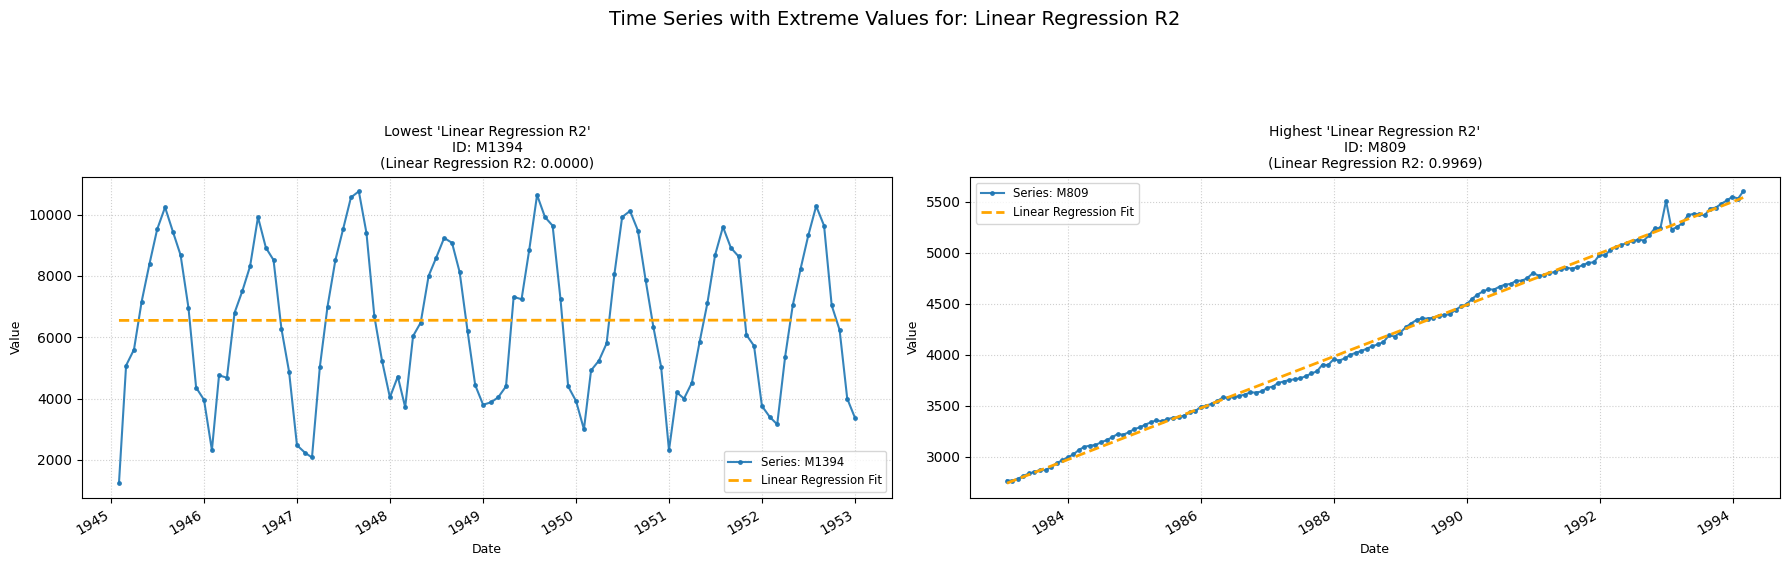

In [14]:
# --- Feature to Plot ---
feature_to_plot = "Linear Regression R2"

# --- Check if data for the feature is available ---
if 'extreme_datasets_info' not in globals() or not extreme_datasets_info or \
   feature_to_plot not in extreme_datasets_info or not extreme_datasets_info[feature_to_plot]:
    fig, ax_placeholder = plt.subplots(1, 1, figsize=(9, 5))
    ax_placeholder.text(0.5, 0.5, f"No extreme data found for\n'{feature_to_plot}'", ha='center', va='center', fontsize=12)
    ax_placeholder.set_xticks([])
    ax_placeholder.set_yticks([])
    ax_placeholder.set_title(f"Extreme Values: {feature_to_plot}")
    plt.show()
else:
    details = extreme_datasets_info[feature_to_plot]
    ids_to_process_map = {
        f"Lowest '{feature_to_plot}'": details["low_id"],
        f"Highest '{feature_to_plot}'": details["high_id"]
    }
    
    stored_values_map = {
        f"Lowest '{feature_to_plot}'": details["low_val"],
        f"Highest '{feature_to_plot}'": details["high_val"]
    }

    valid_plots_info = []
    for desc, target_id in ids_to_process_map.items():
        if target_id != "N/A" and target_id is not None:
            valid_plots_info.append({"desc": desc, "id": str(target_id), "stored_val": stored_values_map[desc]})

    if not valid_plots_info:
        fig, ax_placeholder = plt.subplots(1, 1, figsize=(9, 5))
        ax_placeholder.text(0.5, 0.5, f"No valid series IDs found for\n'{feature_to_plot}' extremes.", ha='center', va='center', fontsize=12)
        ax_placeholder.set_xticks([])
        ax_placeholder.set_yticks([])
        ax_placeholder.set_title(f"Extreme Values: {feature_to_plot}")
        plt.show()
    else:
        num_plots = len(valid_plots_info)
        fig, axes = plt.subplots(1, num_plots, figsize=(9 * num_plots, 5.5), squeeze=False)
        axes = axes.flatten() 

        for i, plot_info in enumerate(valid_plots_info):
            ax = axes[i]
            target_id = plot_info["id"]
            plot_title_desc = plot_info["desc"]
            stored_feature_val = plot_info["stored_val"]

            if 'Y_df' not in globals() or Y_df is None:
                ax.set_title(f"{plot_title_desc}\nID: {target_id}\n(Y_df MISSING)")
                ax.text(0.5, 0.5, 'Y_df MISSING', ha='center', va='center')
                ax.set_xticks([]); ax.set_yticks([])
                continue

            series_df = Y_df[Y_df['unique_id'] == target_id].sort_values('ds')

            if series_df.empty:
                ax.set_title(f"{plot_title_desc}\nID: {target_id}\n(Data Missing)")
                ax.text(0.5, 0.5, 'Data Missing', ha='center', va='center')
                ax.set_xticks([]); ax.set_yticks([])
                continue

            series_np = series_df['y'].to_numpy()
            series_dates = series_df['ds']
            
            if len(series_np) < 2: # Linear regression requires at least 2 points.
                ax.set_title(f"{plot_title_desc}\nID: {target_id}\n(Series Too Short: {len(series_np)})")
                ax.text(0.5, 0.5, 'Series Too Short', ha='center', va='center')
                ax.set_xticks([]); ax.set_yticks([])
                continue

            # --- Calculation for Linear Regression ---
            regression_line_to_plot = None
            
            time_steps = np.arange(len(series_np)).reshape(-1, 1)
            try:
                model = SkLearnLinearRegression()
                model.fit(time_steps, series_np)
                regression_line_to_plot = model.predict(time_steps)
            except NameError: 
                print("ERROR: SkLearnLinearRegression not defined. Please import it.")
                ax.text(0.5, 0.5, 'LR Calc Error\n(Import Missing)', ha='center', va='center')
            except Exception: 
                ax.text(0.5, 0.5, 'LR Calc Error', ha='center', va='center')


            # --- Plotting ---
            ax.plot(series_dates, series_np, marker='.', linestyle='-', markersize=5, label=f"Series: {target_id}", alpha=0.9)

            if regression_line_to_plot is not None:
                ax.plot(series_dates, regression_line_to_plot, linestyle='--', color='orange', lw=2, label="Linear Regression Fit")
            
            title_parts = [f"{plot_title_desc}", f"ID: {target_id}"]
            if pd.notna(stored_feature_val): 
                title_parts.append(f"({feature_to_plot}: {stored_feature_val if isinstance(stored_feature_val, str) else f'{stored_feature_val:.4f}'})") 
            
            ax.set_title("\n".join(title_parts), fontsize=10)
            
            if any(ax.get_legend_handles_labels()[1]): 
                ax.legend(fontsize='small', loc='best')
            
            ax.set_xlabel("Date", fontsize=9)
            ax.set_ylabel("Value", fontsize=9)
            ax.grid(True, linestyle=':', alpha=0.6)
            plt.setp(ax.get_xticklabels(), rotation=30, ha='right')
        
        fig.suptitle(f"Time Series with Extreme Values for: {feature_to_plot}", fontsize=14, y=1.05 if num_plots > 0 else 0.95)
        plt.tight_layout(rect=[0, 0.03, 1, 0.93])
        plt.show()
        plt.close(fig)

In [15]:
parameter_details_list = [
]

display_parameter_table(
    parameter_details_list)

**No parameters**

## forecastability

Measures the forecastibility of a time-series.  
**Low value:** Means there are strong signs of a trend across the time-series.  
**High value:** Means the time-series is probably white-noise.

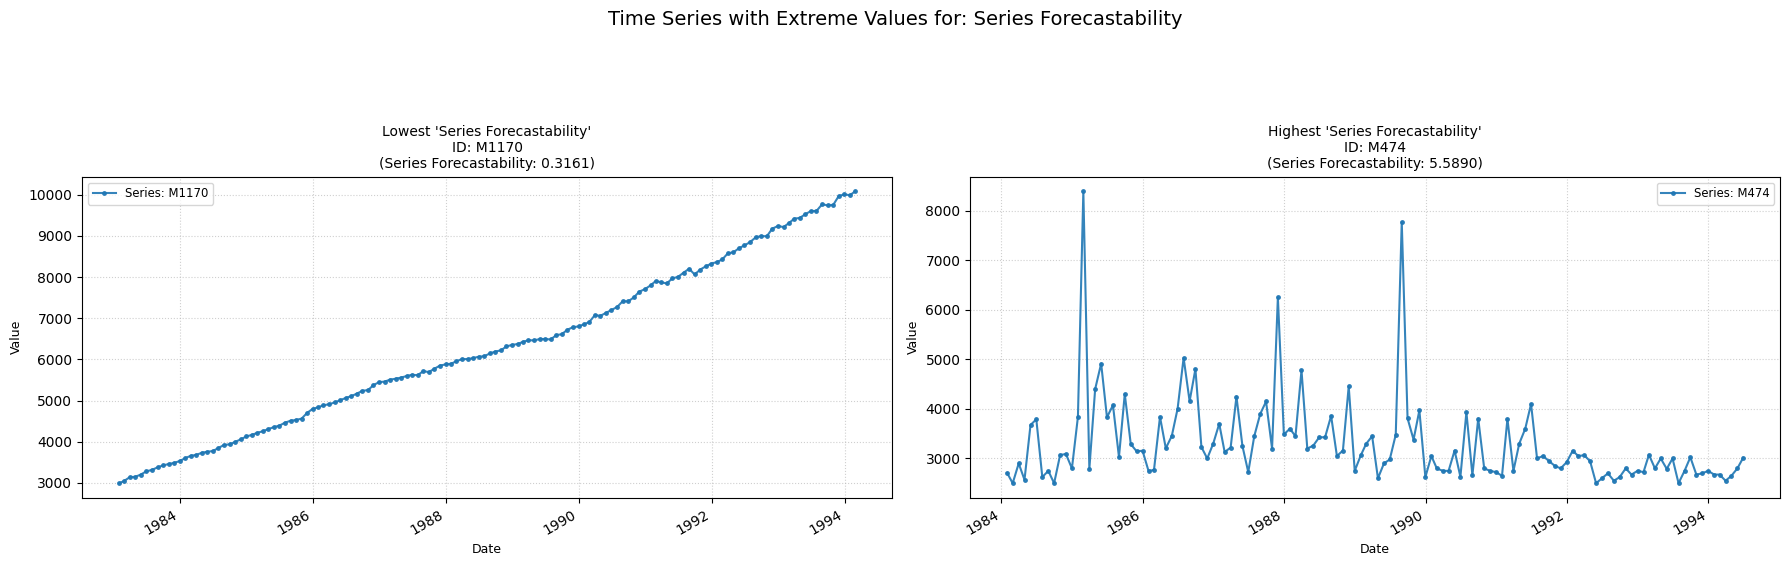

In [16]:
# --- Feature to Plot ---
feature_to_plot = "Series Forecastability" 

# --- Check if data for the feature is available ---
if 'extreme_datasets_info' not in globals() or not extreme_datasets_info or \
   feature_to_plot not in extreme_datasets_info or not extreme_datasets_info[feature_to_plot]:
    fig, ax_placeholder = plt.subplots(1, 1, figsize=(9, 5))
    ax_placeholder.text(0.5, 0.5, f"No extreme data found for\n'{feature_to_plot}'", ha='center', va='center', fontsize=12)
    ax_placeholder.set_xticks([])
    ax_placeholder.set_yticks([])
    ax_placeholder.set_title(f"Extreme Values: {feature_to_plot}")
    plt.show()
else:
    details = extreme_datasets_info[feature_to_plot]
    ids_to_process_map = {
        f"Lowest '{feature_to_plot}'": details["low_id"],
        f"Highest '{feature_to_plot}'": details["high_id"]
    }
    
    stored_values_map = {
        f"Lowest '{feature_to_plot}'": details["low_val"],
        f"Highest '{feature_to_plot}'": details["high_val"]
    }

    valid_plots_info = []
    for desc, target_id in ids_to_process_map.items():
        if target_id != "N/A" and target_id is not None:
            valid_plots_info.append({"desc": desc, "id": str(target_id), "stored_val": stored_values_map[desc]})

    if not valid_plots_info:
        fig, ax_placeholder = plt.subplots(1, 1, figsize=(9, 5))
        ax_placeholder.text(0.5, 0.5, f"No valid series IDs found for\n'{feature_to_plot}' extremes.", ha='center', va='center', fontsize=12)
        ax_placeholder.set_xticks([])
        ax_placeholder.set_yticks([])
        ax_placeholder.set_title(f"Extreme Values: {feature_to_plot}")
        plt.show()
    else:
        num_plots = len(valid_plots_info)
        fig, axes = plt.subplots(1, num_plots, figsize=(9 * num_plots, 5.5), squeeze=False)
        axes = axes.flatten() 

        for i, plot_info in enumerate(valid_plots_info):
            ax = axes[i]
            target_id = plot_info["id"]
            plot_title_desc = plot_info["desc"]
            stored_feature_val = plot_info["stored_val"]

            if 'Y_df' not in globals() or Y_df is None:
                ax.set_title(f"{plot_title_desc}\nID: {target_id}\n(Y_df MISSING)")
                ax.text(0.5, 0.5, 'Y_df MISSING', ha='center', va='center')
                ax.set_xticks([]); ax.set_yticks([])
                continue

            series_df = Y_df[Y_df['unique_id'] == target_id].sort_values('ds')

            if series_df.empty:
                ax.set_title(f"{plot_title_desc}\nID: {target_id}\n(Data Missing)")
                ax.text(0.5, 0.5, 'Data Missing', ha='center', va='center')
                ax.set_xticks([]); ax.set_yticks([])
                continue

            series_np = series_df['y'].to_numpy()
            series_dates = series_df['ds']
            
            if len(series_np) < 2: 
                ax.set_title(f"{plot_title_desc}\nID: {target_id}\n(Series Too Short: {len(series_np)})")
                ax.text(0.5, 0.5, 'Series Too Short', ha='center', va='center')
                ax.set_xticks([]); ax.set_yticks([])
                continue


            # --- Plotting ---
            ax.plot(series_dates, series_np, marker='.', linestyle='-', markersize=5, label=f"Series: {target_id}", alpha=0.9)
            
            title_parts = [f"{plot_title_desc}", f"ID: {target_id}"]
            if pd.notna(stored_feature_val): 
                title_parts.append(f"({feature_to_plot}: {stored_feature_val if isinstance(stored_feature_val, str) else f'{stored_feature_val:.4f}'})") 
            
            ax.set_title("\n".join(title_parts), fontsize=10)
            
            if any(ax.get_legend_handles_labels()[1]): 
                ax.legend(fontsize='small', loc='best')
            
            ax.set_xlabel("Date", fontsize=9)
            ax.set_ylabel("Value", fontsize=9)
            ax.grid(True, linestyle=':', alpha=0.6)
            plt.setp(ax.get_xticklabels(), rotation=30, ha='right')
        
        fig.suptitle(f"Time Series with Extreme Values for: {feature_to_plot}", fontsize=14, y=1.05 if num_plots > 0 else 0.95)
        plt.tight_layout(rect=[0, 0.03, 1, 0.93])
        plt.show()
        plt.close(fig)

In [17]:
parameter_details_list = [
    {
        "Parameter": "sf", "Type": "float", 
        "Description": "Sampling frequency.", 
        "Default": "Mandatory"
    },
    {
        "Parameter": "method", "Type": "str",
        "Description": "PSD calculation method ('welch' or 'fft').",
        "Default": "welch"
    },
    {
        "Parameter": "nperseg", "Type": "int or None",
        "Description": "Segment length for welch method. If None, default based on data length",
        "Default": "None"
    },
    {
        "Parameter": "normalize", "Type": "bool",
        "Description": "Normalize output to [0, 1]",
        "Default": "False"
    }
]

display_parameter_table(
    parameter_details_list)

Parameter,Type,Default,Description
sf,float,Mandatory,Sampling frequency.
method,str,welch,PSD calculation method ('welch' or 'fft').
nperseg,int or None,None,"Segment length for welch method. If None, default based on data length"
normalize,bool,False,"Normalize output to [0, 1]"


## entropy_pairs

Measures entropy based on the 3 quantile bins of the time-series.  
**Low value:** Means simpler patterns in the time-series sequence.  
**High value:** Means more complex patterns in the time-series sequence.

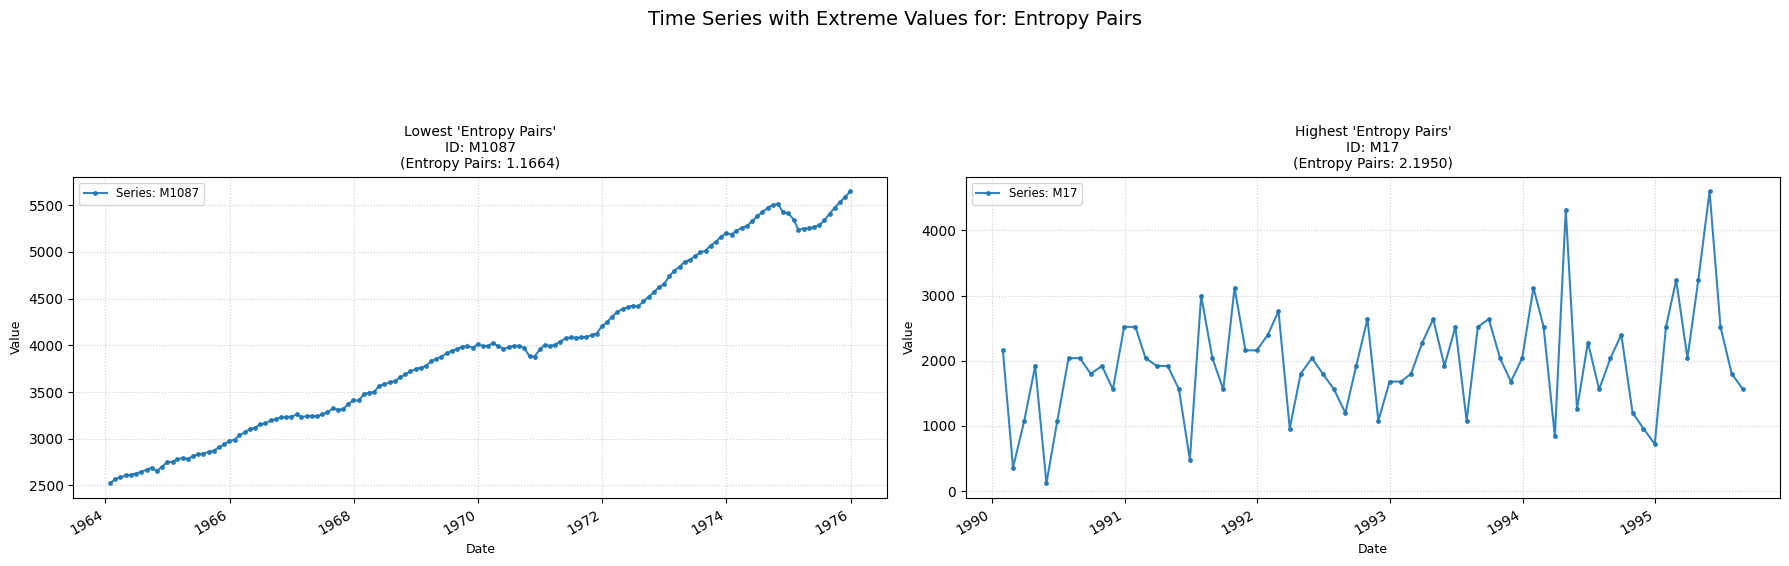

In [18]:
# --- Feature to Plot ---
feature_to_plot = "Entropy Pairs"

# --- Check if data for the feature is available ---
if 'extreme_datasets_info' not in globals() or not extreme_datasets_info or \
   feature_to_plot not in extreme_datasets_info or not extreme_datasets_info[feature_to_plot]:
    fig, ax_placeholder = plt.subplots(1, 1, figsize=(9, 5))
    ax_placeholder.text(0.5, 0.5, f"No extreme data found for\n'{feature_to_plot}'", ha='center', va='center', fontsize=12)
    ax_placeholder.set_xticks([])
    ax_placeholder.set_yticks([])
    ax_placeholder.set_title(f"Extreme Values: {feature_to_plot}")
    plt.show()
else:
    details = extreme_datasets_info[feature_to_plot]
    ids_to_process_map = {
        f"Lowest '{feature_to_plot}'": details["low_id"],
        f"Highest '{feature_to_plot}'": details["high_id"]
    }
    
    stored_values_map = {
        f"Lowest '{feature_to_plot}'": details["low_val"],
        f"Highest '{feature_to_plot}'": details["high_val"]
    }

    valid_plots_info = []
    for desc, target_id in ids_to_process_map.items():
        if target_id != "N/A" and target_id is not None:
            valid_plots_info.append({"desc": desc, "id": str(target_id), "stored_val": stored_values_map[desc]})

    if not valid_plots_info:
        fig, ax_placeholder = plt.subplots(1, 1, figsize=(9, 5))
        ax_placeholder.text(0.5, 0.5, f"No valid series IDs found for\n'{feature_to_plot}' extremes.", ha='center', va='center', fontsize=12)
        ax_placeholder.set_xticks([])
        ax_placeholder.set_yticks([])
        ax_placeholder.set_title(f"Extreme Values: {feature_to_plot}")
        plt.show()
    else:
        num_plots = len(valid_plots_info)
        fig, axes = plt.subplots(1, num_plots, figsize=(9 * num_plots, 5.5), squeeze=False)
        axes = axes.flatten() 

        for i, plot_info in enumerate(valid_plots_info):
            ax = axes[i]
            target_id = plot_info["id"]
            plot_title_desc = plot_info["desc"]
            stored_feature_val = plot_info["stored_val"]

            if 'Y_df' not in globals() or Y_df is None:
                ax.set_title(f"{plot_title_desc}\nID: {target_id}\n(Y_df MISSING)")
                ax.text(0.5, 0.5, 'Y_df MISSING', ha='center', va='center')
                ax.set_xticks([]); ax.set_yticks([])
                continue

            series_df = Y_df[Y_df['unique_id'] == target_id].sort_values('ds')

            if series_df.empty:
                ax.set_title(f"{plot_title_desc}\nID: {target_id}\n(Data Missing)")
                ax.text(0.5, 0.5, 'Data Missing', ha='center', va='center')
                ax.set_xticks([]); ax.set_yticks([])
                continue

            series_np = series_df['y'].to_numpy()
            series_dates = series_df['ds']
            
            if len(series_np) < 2: 
                ax.set_title(f"{plot_title_desc}\nID: {target_id}\n(Series Too Short: {len(series_np)})")
                ax.text(0.5, 0.5, 'Series Too Short', ha='center', va='center')
                ax.set_xticks([]); ax.set_yticks([])
                continue

            # --- Plotting ---
            ax.plot(series_dates, series_np, marker='.', linestyle='-', markersize=5, label=f"Series: {target_id}", alpha=0.9)
            
            title_parts = [f"{plot_title_desc}", f"ID: {target_id}"]
            if pd.notna(stored_feature_val): 
                title_parts.append(f"({feature_to_plot}: {stored_feature_val if isinstance(stored_feature_val, str) else f'{stored_feature_val:.4f}'})") 
            
            ax.set_title("\n".join(title_parts), fontsize=10)
            
            if any(ax.get_legend_handles_labels()[1]): 
                ax.legend(fontsize='small', loc='best')
            
            ax.set_xlabel("Date", fontsize=9)
            ax.set_ylabel("Value", fontsize=9)
            ax.grid(True, linestyle=':', alpha=0.6)
            plt.setp(ax.get_xticklabels(), rotation=30, ha='right')
        
        fig.suptitle(f"Time Series with Extreme Values for: {feature_to_plot}", fontsize=14, y=1.05 if num_plots > 0 else 0.95)
        plt.tight_layout(rect=[0, 0.03, 1, 0.93])
        plt.show()
        plt.close(fig)

In [19]:
parameter_details_list = [
]

display_parameter_table(
    parameter_details_list)

**No parameters**

## fluctuation

Measures the proportion of large changes in the time-series.  
**Low value:** Means few/none large fluctuations.  
**High value:** Means many large fluctuations.

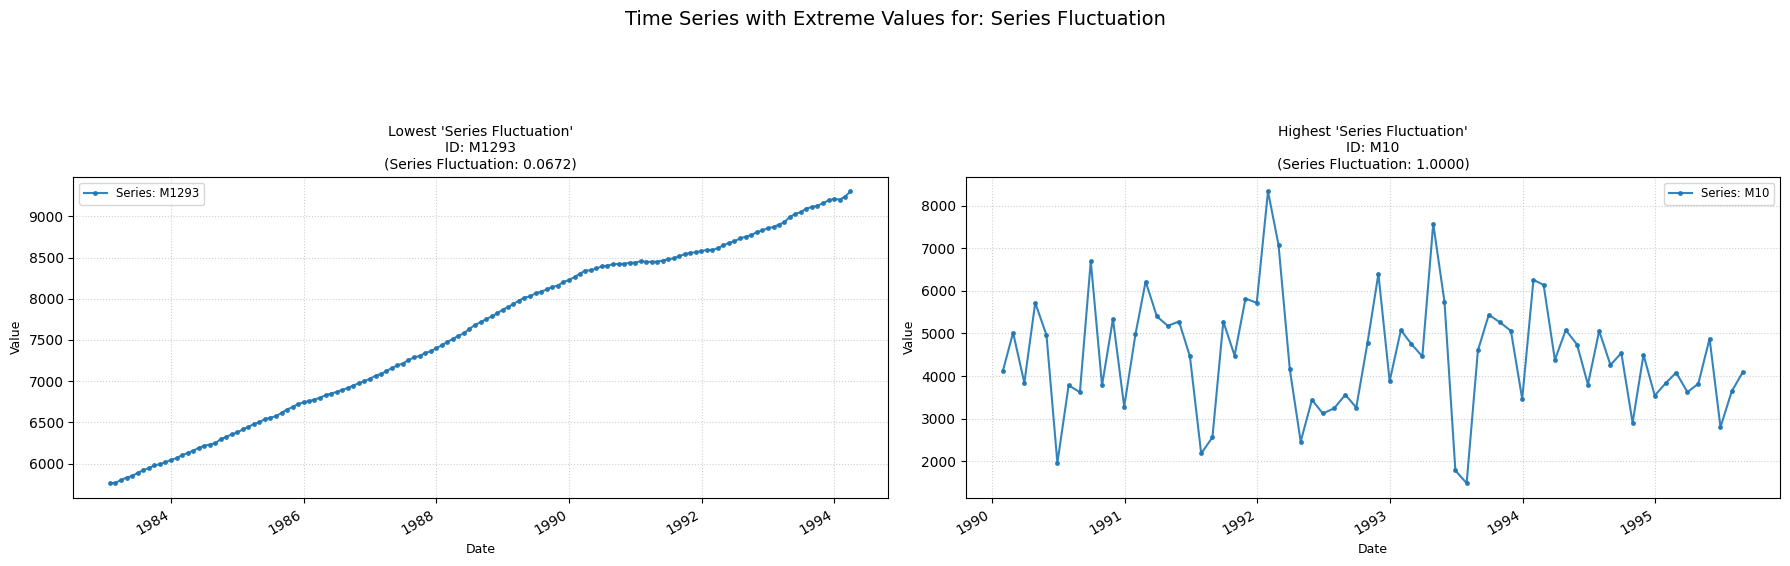

In [20]:
# --- Feature to Plot ---
feature_to_plot = "Series Fluctuation" 

# --- Check if data for the feature is available ---
if 'extreme_datasets_info' not in globals() or not extreme_datasets_info or \
   feature_to_plot not in extreme_datasets_info or not extreme_datasets_info[feature_to_plot]:
    fig, ax_placeholder = plt.subplots(1, 1, figsize=(9, 5))
    ax_placeholder.text(0.5, 0.5, f"No extreme data found for\n'{feature_to_plot}'", ha='center', va='center', fontsize=12)
    ax_placeholder.set_xticks([])
    ax_placeholder.set_yticks([])
    ax_placeholder.set_title(f"Extreme Values: {feature_to_plot}")
    plt.show()
else:
    details = extreme_datasets_info[feature_to_plot]
    ids_to_process_map = {
        f"Lowest '{feature_to_plot}'": details["low_id"],
        f"Highest '{feature_to_plot}'": details["high_id"]
    }
    
    stored_values_map = {
        f"Lowest '{feature_to_plot}'": details["low_val"],
        f"Highest '{feature_to_plot}'": details["high_val"]
    }

    valid_plots_info = []
    for desc, target_id in ids_to_process_map.items():
        if target_id != "N/A" and target_id is not None:
            valid_plots_info.append({"desc": desc, "id": str(target_id), "stored_val": stored_values_map[desc]})

    if not valid_plots_info:
        fig, ax_placeholder = plt.subplots(1, 1, figsize=(9, 5))
        ax_placeholder.text(0.5, 0.5, f"No valid series IDs found for\n'{feature_to_plot}' extremes.", ha='center', va='center', fontsize=12)
        ax_placeholder.set_xticks([])
        ax_placeholder.set_yticks([])
        ax_placeholder.set_title(f"Extreme Values: {feature_to_plot}")
        plt.show()
    else:
        num_plots = len(valid_plots_info)
        fig, axes = plt.subplots(1, num_plots, figsize=(9 * num_plots, 5.5), squeeze=False)
        axes = axes.flatten() 

        for i, plot_info in enumerate(valid_plots_info):
            ax = axes[i]
            target_id = plot_info["id"]
            plot_title_desc = plot_info["desc"]
            stored_feature_val = plot_info["stored_val"] 

            if 'Y_df' not in globals() or Y_df is None:
                ax.set_title(f"{plot_title_desc}\nID: {target_id}\n(Y_df MISSING)")
                ax.text(0.5, 0.5, 'Y_df MISSING', ha='center', va='center')
                ax.set_xticks([]); ax.set_yticks([])
                continue

            series_df = Y_df[Y_df['unique_id'] == target_id].sort_values('ds')

            if series_df.empty:
                ax.set_title(f"{plot_title_desc}\nID: {target_id}\n(Data Missing)")
                ax.text(0.5, 0.5, 'Data Missing', ha='center', va='center')
                ax.set_xticks([]); ax.set_yticks([])
                continue

            series_np = series_df['y'].to_numpy()
            series_dates = series_df['ds']
            
            if len(series_np) < 2: 
                ax.set_title(f"{plot_title_desc}\nID: {target_id}\n(Series Too Short: {len(series_np)})")
                ax.text(0.5, 0.5, 'Series Too Short', ha='center', va='center')
                ax.set_xticks([]); ax.set_yticks([])
                continue

            # --- Plotting ---
            ax.plot(series_dates, series_np, marker='.', linestyle='-', markersize=5, label=f"Series: {target_id}", alpha=0.9)
            
            title_parts = [f"{plot_title_desc}", f"ID: {target_id}"]
            if pd.notna(stored_feature_val): 
                title_parts.append(f"({feature_to_plot}: {stored_feature_val if isinstance(stored_feature_val, str) else f'{stored_feature_val:.4f}'})") 
            
            ax.set_title("\n".join(title_parts), fontsize=10)
            
            if any(ax.get_legend_handles_labels()[1]): 
                ax.legend(fontsize='small', loc='best')
            
            ax.set_xlabel("Date", fontsize=9)
            ax.set_ylabel("Value", fontsize=9)
            ax.grid(True, linestyle=':', alpha=0.6)
            plt.setp(ax.get_xticklabels(), rotation=30, ha='right')
        
        fig.suptitle(f"Time Series with Extreme Values for: {feature_to_plot}", fontsize=14, y=1.05 if num_plots > 0 else 0.95)
        plt.tight_layout(rect=[0, 0.03, 1, 0.93])
        plt.show()
        plt.close(fig)

In [21]:
parameter_details_list = [
]

display_parameter_table(
    parameter_details_list)

**No parameters**

## ac_relevance

Measures the first time lag at which the autocorrelation function drops below 1/e.

**Low value:** Means the series has a more unpredicatble behaviour.  
**High value:** Means the series has a more predictable behaviour.

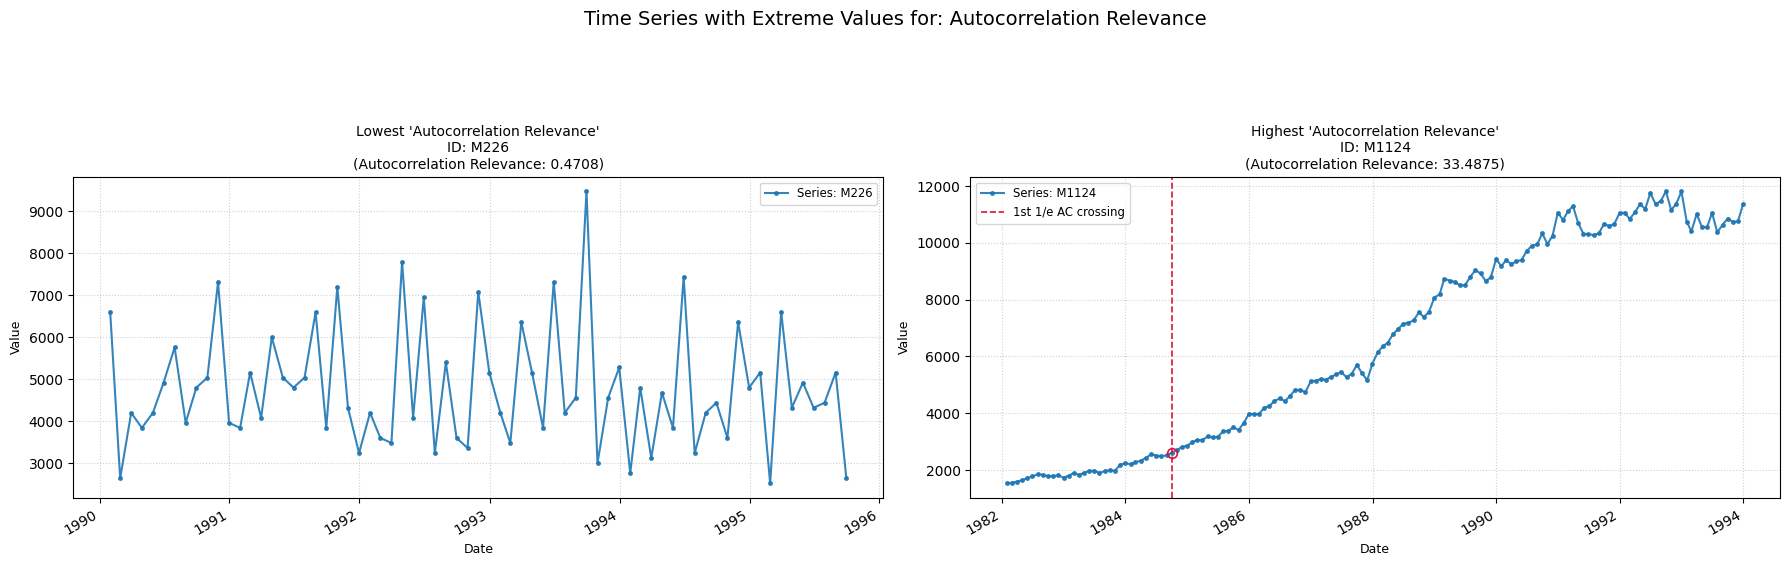

In [32]:
# --- Feature to Plot ---
feature_to_plot = "Autocorrelation Relevance" 

# --- Check if data for the feature is available ---
if 'extreme_datasets_info' not in globals() or not extreme_datasets_info or \
   feature_to_plot not in extreme_datasets_info or not extreme_datasets_info[feature_to_plot]:
    fig, ax_placeholder = plt.subplots(1, 1, figsize=(9, 5))
    ax_placeholder.text(0.5, 0.5, f"No extreme data found for\n'{feature_to_plot}'", ha='center', va='center', fontsize=12)
    ax_placeholder.set_xticks([])
    ax_placeholder.set_yticks([])
    ax_placeholder.set_title(f"Extreme Values: {feature_to_plot}")
    plt.show()
else:
    details = extreme_datasets_info[feature_to_plot]
    ids_to_process_map = {
        f"Lowest '{feature_to_plot}'": details["low_id"],
        f"Highest '{feature_to_plot}'": details["high_id"]
    }
    
    stored_values_map = {
        f"Lowest '{feature_to_plot}'": details["low_val"],
        f"Highest '{feature_to_plot}'": details["high_val"]
    }

    valid_plots_info = []
    for desc, target_id in ids_to_process_map.items():
        if target_id != "N/A" and target_id is not None:
            valid_plots_info.append({"desc": desc, "id": str(target_id), "stored_val": stored_values_map[desc]})

    if not valid_plots_info:
        fig, ax_placeholder = plt.subplots(1, 1, figsize=(9, 5))
        ax_placeholder.text(0.5, 0.5, f"No valid series IDs found for\n'{feature_to_plot}' extremes.", ha='center', va='center', fontsize=12)
        ax_placeholder.set_xticks([])
        ax_placeholder.set_yticks([])
        ax_placeholder.set_title(f"Extreme Values: {feature_to_plot}")
        plt.show()
    else:
        num_plots = len(valid_plots_info)
        fig, axes = plt.subplots(1, num_plots, figsize=(9 * num_plots, 5.5), squeeze=False)
        axes = axes.flatten() 

        for i, plot_info in enumerate(valid_plots_info):
            ax = axes[i]
            target_id = plot_info["id"]
            plot_title_desc = plot_info["desc"]
            stored_feature_val = plot_info["stored_val"] 

            if 'Y_df' not in globals() or Y_df is None:
                ax.set_title(f"{plot_title_desc}\nID: {target_id}\n(Y_df MISSING)")
                ax.text(0.5, 0.5, 'Y_df MISSING', ha='center', va='center')
                ax.set_xticks([]); ax.set_yticks([])
                continue

            series_df = Y_df[Y_df['unique_id'] == target_id].sort_values('ds')

            if series_df.empty:
                ax.set_title(f"{plot_title_desc}\nID: {target_id}\n(Data Missing)")
                ax.text(0.5, 0.5, 'Data Missing', ha='center', va='center')
                ax.set_xticks([]); ax.set_yticks([])
                continue

            series_np = series_df['y'].to_numpy()
            series_dates = series_df['ds']
            
            if len(series_np) < 2: 
                ax.set_title(f"{plot_title_desc}\nID: {target_id}\n(Series Too Short: {len(series_np)})")
                ax.text(0.5, 0.5, 'Series Too Short', ha='center', va='center')
                ax.set_xticks([]); ax.set_yticks([])
                continue

            # --- Plotting ---
            ax.plot(series_dates, series_np, marker='.', linestyle='-', markersize=5, label=f"Series: {target_id}", alpha=0.9)
            
            lag_value = stored_feature_val
            if pd.notna(lag_value) and isinstance(lag_value, (int, float, np.number)) and lag_value >= 1:
                lag_index_to_mark = int(round(lag_value)) - 1
                if 0 <= lag_index_to_mark < len(series_dates):
                    crossing_date = series_dates.iloc[lag_index_to_mark]
                    crossing_value_on_series = series_np[lag_index_to_mark]
                    ax.axvline(x=crossing_date, color='crimson', linestyle='--', linewidth=1.2, label=f'1st 1/e AC crossing')
                    ax.plot(crossing_date, crossing_value_on_series, marker='o', color='crimson', markersize=7, fillstyle='none', markeredgewidth=1.2)

            title_parts = [f"{plot_title_desc}", f"ID: {target_id}"]
            if pd.notna(stored_feature_val): 
                title_parts.append(f"({feature_to_plot}: {stored_feature_val if isinstance(stored_feature_val, str) else f'{stored_feature_val:.4f}'})") 
            
            ax.set_title("\n".join(title_parts), fontsize=10)
            
            if any(ax.get_legend_handles_labels()[1]): 
                ax.legend(fontsize='small', loc='best')
            
            ax.set_xlabel("Date", fontsize=9)
            ax.set_ylabel("Value", fontsize=9)
            ax.grid(True, linestyle=':', alpha=0.6)
            plt.setp(ax.get_xticklabels(), rotation=30, ha='right')
        
        fig.suptitle(f"Time Series with Extreme Values for: {feature_to_plot}", fontsize=14, y=1.05 if num_plots > 0 else 0.95)
        plt.tight_layout(rect=[0, 0.03, 1, 0.93])
        plt.show()
        plt.close(fig)

In [25]:
parameter_details_list = [
]

display_parameter_table(
    parameter_details_list)

**No parameters**

## seasonal_strength

Computes the strength of seasonality within the time-series.

**Low value:** A value close to zero means there are few/none indicators of seasonality in the time series.  
**High value:** A value close to one means there are strong signs of seasonality in the time-series.

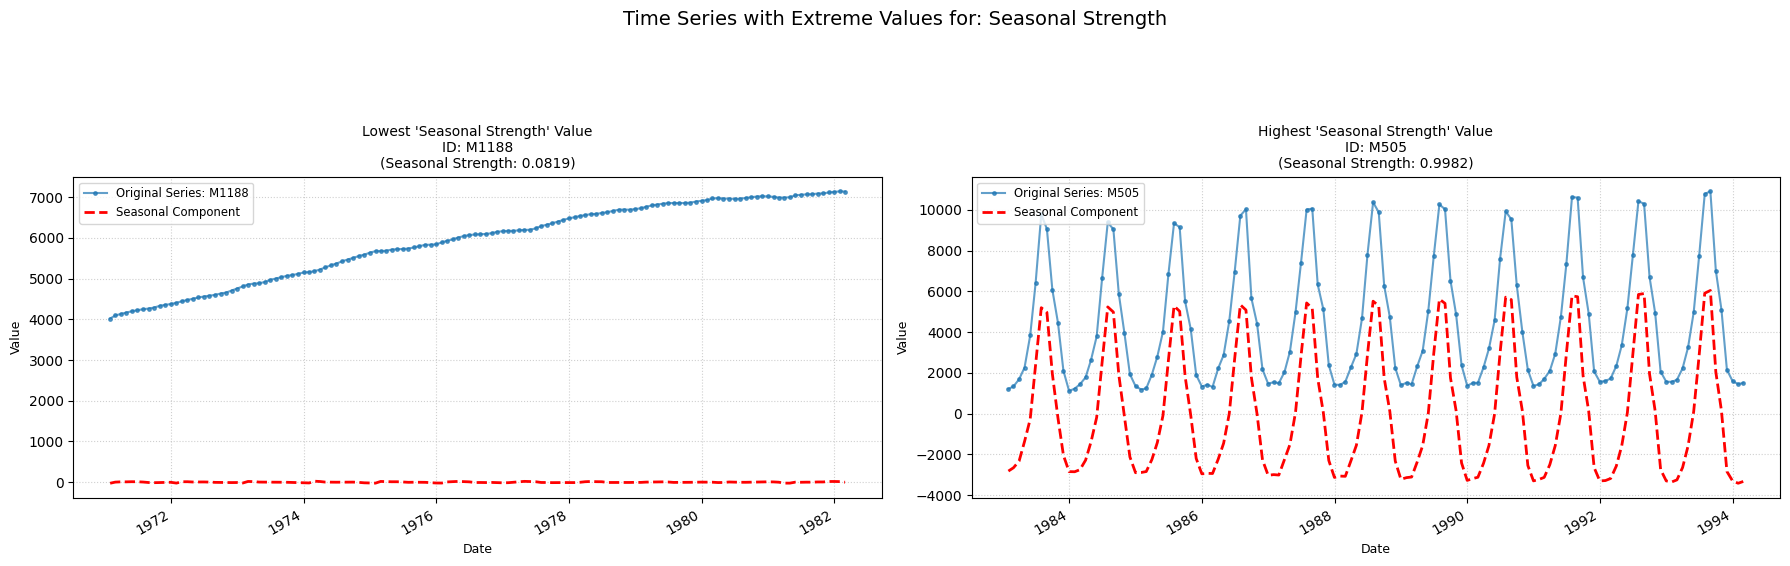

In [31]:
# --- Feature to Plot ---
feature_to_plot = "Seasonal Strength"

# --- Check if data for the feature is available ---
if feature_to_plot not in extreme_datasets_info or not extreme_datasets_info[feature_to_plot]:
    fig, ax_placeholder = plt.subplots(1, 1, figsize=(9, 5))
    ax_placeholder.text(0.5, 0.5, f"No extreme data found for\n'{feature_to_plot}'", ha='center', va='center', fontsize=12)
    ax_placeholder.set_xticks([])
    ax_placeholder.set_yticks([])
    ax_placeholder.set_title(f"Extreme Values: {feature_to_plot}")
    plt.show()
else:
    details = extreme_datasets_info[feature_to_plot]
    ids_to_process_map = {
        f"Lowest '{feature_to_plot}' Value": details["low_id"],
        f"Highest '{feature_to_plot}' Value": details["high_id"]
    }
    
    stored_values_map = {
        f"Lowest '{feature_to_plot}' Value": details["low_val"],
        f"Highest '{feature_to_plot}' Value": details["high_val"]
    }

    valid_plots_info = []
    for desc, target_id in ids_to_process_map.items():
        if target_id != "N/A" and target_id is not None:
            valid_plots_info.append({"desc": desc, "id": str(target_id), "stored_val": stored_values_map[desc]})

    if not valid_plots_info:
        fig, ax_placeholder = plt.subplots(1, 1, figsize=(9, 5))
        ax_placeholder.text(0.5, 0.5, f"No valid series IDs found for\n'{feature_to_plot}' extremes.", ha='center', va='center', fontsize=12)
        ax_placeholder.set_xticks([])
        ax_placeholder.set_yticks([])
        ax_placeholder.set_title(f"Extreme Values: {feature_to_plot}")
        plt.show()
    else:
        num_plots = len(valid_plots_info)
        fig, axes = plt.subplots(1, num_plots, figsize=(9 * num_plots, 5.5), squeeze=False)
        axes = axes.flatten() 

        for i, plot_info in enumerate(valid_plots_info):
            ax = axes[i]
            target_id = plot_info["id"]
            plot_title_desc = plot_info["desc"]
            stored_feature_val = plot_info["stored_val"]

            if 'Y_df' not in globals() or Y_df is None:
                ax.set_title(f"{plot_title_desc}\nID: {target_id}\n(Y_df MISSING)")
                ax.text(0.5, 0.5, 'Y_df MISSING', ha='center', va='center')
                ax.set_xticks([]); ax.set_yticks([])
                continue

            series_df = Y_df[Y_df['unique_id'] == target_id].sort_values('ds')

            if series_df.empty:
                ax.set_title(f"{plot_title_desc}\nID: {target_id}\n(Data Missing)")
                ax.text(0.5, 0.5, 'Data Missing', ha='center', va='center')
                ax.set_xticks([]); ax.set_yticks([])
                continue

            series_np = series_df['y'].to_numpy()
            series_dates = series_df['ds']

            seasonal_period_for_stl = 12 
            seasonal_smoother_len = 7  
            
            if len(series_np) <= 2 * seasonal_smoother_len :
                ax.set_title(f"{plot_title_desc}\nID: {target_id}\n(Series Too Short for STL: {len(series_np)})")
                ax.text(0.5, 0.5, 'Series Too Short for STL', ha='center', va='center')
                ax.set_xticks([]); ax.set_yticks([])
                continue

            # --- STL Decomposition for "Trend Strength" ---
            recalculated_feature_value = np.nan
            trend_component_to_plot = None
            
            try:
                stl = STL(series_np, period=seasonal_period_for_stl, seasonal=seasonal_smoother_len, robust=True)
                res = stl.fit()
                
                trend_component = res.trend
                seasonal_component_to_plot = res.seasonal 
                remainder_component = res.resid  

                var_R = np.var(remainder_component, ddof=1)
                var_TR = np.var(series_np - seasonal_component, ddof=1) 
                
                if var_TR <= 1e-10:
                    recalculated_feature_value = 0.0
                else:
                    recalculated_feature_value = max(0.0, 1.0 - (var_R / var_TR))
            except Exception as e:
                recalculated_feature_value = "STL Error"


            # --- Plotting ---
            ax.plot(series_dates, series_np, marker='.', linestyle='-', markersize=5, label=f"Original Series: {target_id}", alpha=0.7)

            if seasonal_component_to_plot is not None:
                ax.plot(series_dates, seasonal_component_to_plot, linestyle='--', color='red', lw=2, label="Seasonal Component")

            title_parts = [f"{plot_title_desc}", f"ID: {target_id}"]

            if pd.notna(stored_feature_val):
                title_parts.append(f"(Seasonal Strength: {stored_feature_val if isinstance(stored_feature_val, str) else f'{stored_feature_val:.4f}'})")
            
            ax.set_title("\n".join(title_parts), fontsize=10)
            
            if any(ax.get_legend_handles_labels()[1]):
                ax.legend(fontsize='small', loc='best')
            
            ax.set_xlabel("Date", fontsize=9)
            ax.set_ylabel("Value", fontsize=9)
            ax.grid(True, linestyle=':', alpha=0.6)
            plt.setp(ax.get_xticklabels(), rotation=30, ha='right')

        fig.suptitle(f"Time Series with Extreme Values for: {feature_to_plot}", fontsize=14, y=1.05 if num_plots > 0 else 0.95)
        plt.tight_layout(rect=[0, 0.03, 1, 0.93])
        plt.show()
        plt.close(fig)

In [27]:
parameter_details_list = [
    {
        "Parameter": "period", "Type": "int", 
        "Description": "Frequency of the time series (e.g. 12 for monthly)", 
        "Default": "'1'"
    },
    {
        "Parameter": "seasonal", "Type": "int",
        "Description": "Length of the seasonal smoother (must be odd).",
        "Default": "7"
    },
    {
        "Parameter": "robust", "Type": "bool",
        "Description": "Flag for robust fitting.",
        "Default": "False"
    }
]

display_parameter_table(
    parameter_details_list)

Parameter,Type,Default,Description
period,int,'1',Frequency of the time series (e.g. 12 for monthly)
seasonal,int,7,Length of the seasonal smoother (must be odd).
robust,bool,False,Flag for robust fitting.


## window_fluctuation

Measures the proportion of large changes over short time-windows.

**Low value:** Means the fluctuation of the time-series is more structured and shows few signs of randomness.  
**High value:** Means the fluctuation of the time-series shows signs of randomness.

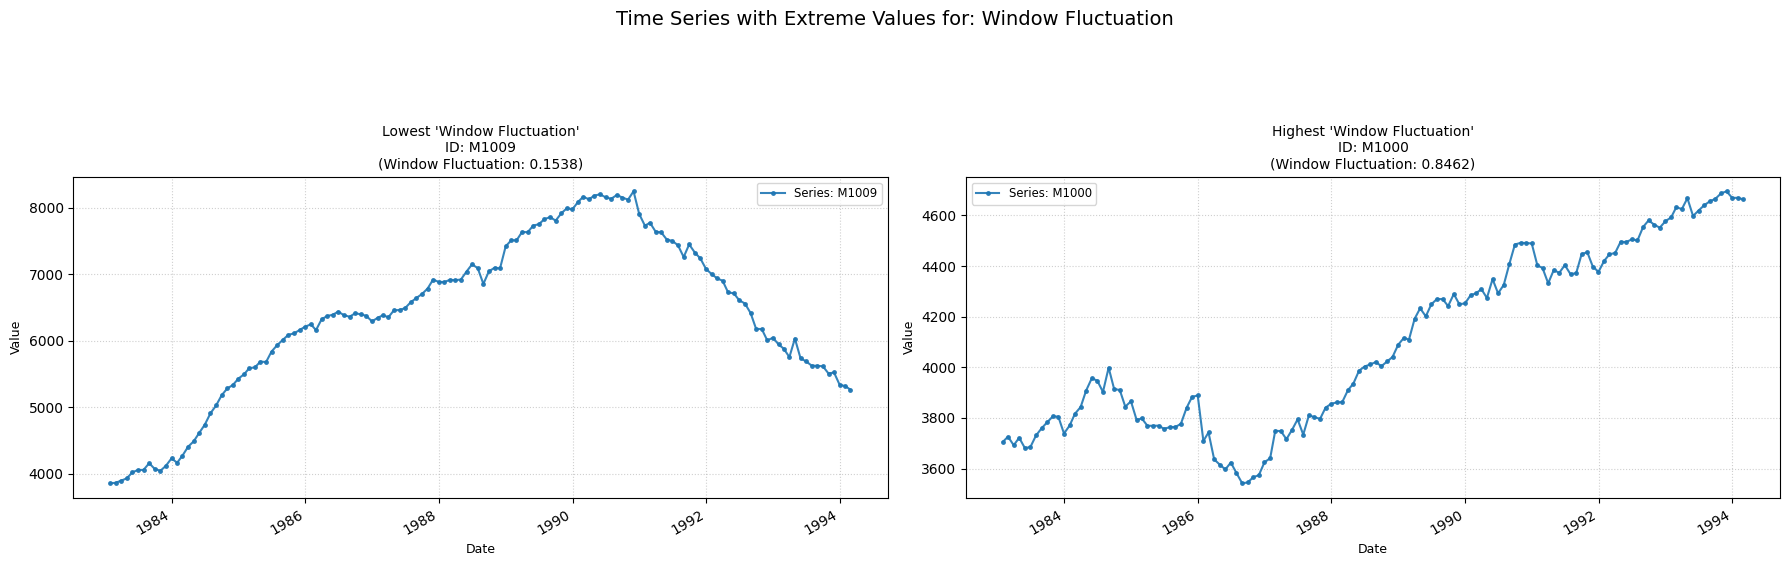

In [34]:
# --- Feature to Plot ---
feature_to_plot = "Window Fluctuation" 

# --- Check if data for the feature is available ---
if 'extreme_datasets_info' not in globals() or not extreme_datasets_info or \
   feature_to_plot not in extreme_datasets_info or not extreme_datasets_info[feature_to_plot]:
    fig, ax_placeholder = plt.subplots(1, 1, figsize=(9, 5))
    ax_placeholder.text(0.5, 0.5, f"No extreme data found for\n'{feature_to_plot}'", ha='center', va='center', fontsize=12)
    ax_placeholder.set_xticks([])
    ax_placeholder.set_yticks([])
    ax_placeholder.set_title(f"Extreme Values: {feature_to_plot}")
    plt.show()
else:
    details = extreme_datasets_info[feature_to_plot]
    ids_to_process_map = {
        f"Lowest '{feature_to_plot}'": details["low_id"],
        f"Highest '{feature_to_plot}'": details["high_id"]
    }
    
    stored_values_map = {
        f"Lowest '{feature_to_plot}'": details["low_val"],
        f"Highest '{feature_to_plot}'": details["high_val"]
    }

    valid_plots_info = []
    for desc, target_id in ids_to_process_map.items():
        if target_id != "N/A" and target_id is not None:
            valid_plots_info.append({"desc": desc, "id": str(target_id), "stored_val": stored_values_map[desc]})

    if not valid_plots_info:
        fig, ax_placeholder = plt.subplots(1, 1, figsize=(9, 5))
        ax_placeholder.text(0.5, 0.5, f"No valid series IDs found for\n'{feature_to_plot}' extremes.", ha='center', va='center', fontsize=12)
        ax_placeholder.set_xticks([])
        ax_placeholder.set_yticks([])
        ax_placeholder.set_title(f"Extreme Values: {feature_to_plot}")
        plt.show()
    else:
        num_plots = len(valid_plots_info)
        fig, axes = plt.subplots(1, num_plots, figsize=(9 * num_plots, 5.5), squeeze=False)
        axes = axes.flatten() 

        for i, plot_info in enumerate(valid_plots_info):
            ax = axes[i]
            target_id = plot_info["id"]
            plot_title_desc = plot_info["desc"]
            stored_feature_val = plot_info["stored_val"] 

            if 'Y_df' not in globals() or Y_df is None:
                ax.set_title(f"{plot_title_desc}\nID: {target_id}\n(Y_df MISSING)")
                ax.text(0.5, 0.5, 'Y_df MISSING', ha='center', va='center')
                ax.set_xticks([]); ax.set_yticks([])
                continue

            series_df = Y_df[Y_df['unique_id'] == target_id].sort_values('ds')

            if series_df.empty:
                ax.set_title(f"{plot_title_desc}\nID: {target_id}\n(Data Missing)")
                ax.text(0.5, 0.5, 'Data Missing', ha='center', va='center')
                ax.set_xticks([]); ax.set_yticks([])
                continue

            series_np = series_df['y'].to_numpy()
            series_dates = series_df['ds']
            
            if len(series_np) < 2: 
                ax.set_title(f"{plot_title_desc}\nID: {target_id}\n(Series Too Short: {len(series_np)})")
                ax.text(0.5, 0.5, 'Series Too Short', ha='center', va='center')
                ax.set_xticks([]); ax.set_yticks([])
                continue

            # --- Plotting ---
            ax.plot(series_dates, series_np, marker='.', linestyle='-', markersize=5, label=f"Series: {target_id}", alpha=0.9)
            
            title_parts = [f"{plot_title_desc}", f"ID: {target_id}"]
            if pd.notna(stored_feature_val): 
                title_parts.append(f"({feature_to_plot}: {stored_feature_val if isinstance(stored_feature_val, str) else f'{stored_feature_val:.4f}'})") 
            
            ax.set_title("\n".join(title_parts), fontsize=10)
            
            if any(ax.get_legend_handles_labels()[1]): 
                ax.legend(fontsize='small', loc='best')
            
            ax.set_xlabel("Date", fontsize=9)
            ax.set_ylabel("Value", fontsize=9)
            ax.grid(True, linestyle=':', alpha=0.6)
            plt.setp(ax.get_xticklabels(), rotation=30, ha='right')
        
        fig.suptitle(f"Time Series with Extreme Values for: {feature_to_plot}", fontsize=14, y=1.05 if num_plots > 0 else 0.95)
        plt.tight_layout(rect=[0, 0.03, 1, 0.93])
        plt.show()
        plt.close(fig)

In [35]:
parameter_details_list = [
]

display_parameter_table(
    parameter_details_list)

**No parameters**